In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
from torch.utils.data import DataLoader
import sys
sys.path.append('/home/mei/nas/docker/thesis/model_train')
from dataloader.graph_ts_reader_30_k_means import VitalSignsDatasetKMeans,vital_dmm_collate_fn
from model.retnet.cvae_learnablec.autoencoder_v5_retnet_kmeans import *
from model.retnet.cvae_learnablec.autoencoder_v5_loss_train_kmeans import *
from model.retnet.cvae_learnablec.plot import *
import seaborn as sns
import matplotlib.pyplot as plt
import gc
gc.collect()
import torch.optim as optim
import torch
torch.cuda.empty_cache()


from torchsampler import ImbalancedDatasetSampler

2025-06-08 00:50:57.532391: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

vital_signs_train = "/home/mei/nas/docker/thesis/data/hdf/train"
vital_signs_val = "/home/mei/nas/docker/thesis/data/hdf/val"
vital_signs_test = "/home/mei/nas/docker/thesis/data/hdf/val"

# --- 2. 创建训练集并fit ---
# 实例化一个完整的dataset对象，用于训练scaler和kmeans
N_CLUSTERS = 64
C_LEN = 10
BATCH_SIZE=32

full_dataset_for_fitting = VitalSignsDatasetKMeans(vital_signs_train, n_clusters=N_CLUSTERS, c_len=C_LEN, is_train=True)
fitted_scaler = full_dataset_for_fitting.scaler
fitted_kmeans = full_dataset_for_fitting.kmeans


dataset_train = VitalSignsDatasetKMeans(vital_signs_train, n_clusters=N_CLUSTERS, c_len=C_LEN, 
                                        is_train=False,
                                        scaler=fitted_scaler, 
                                        kmeans=fitted_kmeans)

dataset_val = VitalSignsDatasetKMeans(vital_signs_val,n_clusters=N_CLUSTERS, c_len=C_LEN, 
                                        is_train=False,
                                        scaler=fitted_scaler, 
                                        kmeans=fitted_kmeans)

dataset_test = VitalSignsDatasetKMeans(vital_signs_test,n_clusters=N_CLUSTERS, c_len=C_LEN, 
                                        is_train=False,
                                        scaler=fitted_scaler, 
                                        kmeans=fitted_kmeans)


train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True, collate_fn=vital_dmm_collate_fn)
val_loader = DataLoader(dataset_val, batch_size=BATCH_SIZE, shuffle=False, collate_fn=vital_dmm_collate_fn)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False, collate_fn=vital_dmm_collate_fn)
train_loader_p = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=False, collate_fn=vital_dmm_collate_fn)


labels_init = [int(dataset_train[i][-1]) for i in range(len(dataset_train))]
train_sampler = ImbalancedDatasetSampler(dataset_train, labels=labels_init)
init_loader = DataLoader( dataset_train,batch_size=100,sampler=train_sampler,collate_fn=vital_dmm_collate_fn )


Preparing training data for global clustering...


Concatenating all patient data: 100%|██████████| 2150/2150 [00:00<00:00, 2303.82it/s]


Fitting StandardScaler...
Fitting KMeans with 64 clusters...
Clustering complete.
Generating and caching cluster labels for each patient...


Caching cluster labels: 100%|██████████| 2150/2150 [00:04<00:00, 474.37it/s]


Generating and caching cluster labels for each patient...


Caching cluster labels: 100%|██████████| 2150/2150 [00:04<00:00, 439.57it/s]


Generating and caching cluster labels for each patient...


Caching cluster labels: 100%|██████████| 461/461 [00:01<00:00, 457.16it/s]


Generating and caching cluster labels for each patient...


Caching cluster labels: 100%|██████████| 461/461 [00:00<00:00, 483.82it/s]


In [ ]:
# from torch.utils.data import Subset

# batch = next(iter(train_loader))
# *_, original_indices,_ = batch
# small_ids = original_indices.tolist()

# small_subset = Subset(dataset_train, small_ids)

# small_train_loader = DataLoader(
#     small_subset,
#     batch_size=len(small_ids),
#     shuffle=True,
#     collate_fn=vital_dmm_collate_fn
# )
# small_train_loader_p = DataLoader(
#     small_subset,
#     batch_size=len(small_ids),
#     shuffle=False,
#     collate_fn=vital_dmm_collate_fn
# )

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/resampled_30_conditional_kmeans"

model = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

optimizer_dmm = optim.Adam(model.dmm.parameters(), lr=1e-3)
optimizer_ae = torch.optim.Adam( list(model.encoder.parameters()) + list(model.decoder.parameters()),lr=1e-3)
optimizer_joint = torch.optim.Adam(model.parameters(), lr=1e-3)

In [4]:
stage1_dir = os.path.join(base_dir, "stage1")
# stage1_dir = os.path.join(base_dir, "stage1_debug")

model1, hist_dmm = train_dmm(model, train_loader, device, optimizer=optimizer_dmm,epochs=100,conditional_loss_weight=1000, save_dir=stage1_dir, patience=50)

[DMM] Starting training...
Epoch 50 Summary: Avg Total Loss: 7.8251, Avg MSE: 0.2950, Avg CE: 0.0075
[VAE Pretrain] Epoch 50/100 Avg loss: 7.8251 (Shift: 0.2950, Condition: 0.0075)
Epoch 100 Summary: Avg Total Loss: 1.4386, Avg MSE: 0.2897, Avg CE: 0.0011
[VAE Pretrain] Epoch 100/100 Avg loss: 1.4386 (Shift: 0.2897, Condition: 0.0011)


In [5]:
stage2_dir = os.path.join(base_dir, "stage2")
# stage2_dir = os.path.join(base_dir, "stage2_debug")

model2, hist_ae = train_vae(model1, train_loader, device, optimizer=optimizer_ae, start=0,epochs=200, save_dir=stage2_dir, patience=50,kl_warmup_epochs=120)

[Epoch 50] KL weight: 0.0041, KL: 2.6777
[VAE Pretrain] Epoch 50/200 Avg ELBO: -394.6572 (Recon: -397.3348, KLw: 2.6777)
[Epoch 100] KL weight: 0.0083, KL: 5.3826
[VAE Pretrain] Epoch 100/200 Avg ELBO: -432.0292 (Recon: -437.4118, KLw: 5.3826)
[Epoch 150] KL weight: 0.0100, KL: 6.7115
[VAE Pretrain] Epoch 150/200 Avg ELBO: -460.4567 (Recon: -467.1682, KLw: 6.7115)
[Epoch 200] KL weight: 0.0100, KL: 6.9775
[VAE Pretrain] Epoch 200/200 Avg ELBO: -487.7694 (Recon: -494.7469, KLw: 6.9775)


In [ ]:
# stage1 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/stage1_debug/best_vae.pth'
# model1 = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

# model1.load_state_dict(torch.load(stage1, map_location=device,weights_only=True))

<All keys matched successfully>

In [6]:
initialize_som_from_data(model2, init_loader, device, som_dim=(10, 10), num_classes=4, samples_per_class=25)

--- Starting SOM Initialization from Data Samples ---


[SOM Init] Collecting latent vectors:   5%|▍         | 1/22 [00:01<00:26,  1.24s/it, Collected=100/100]

Organizing collected vectors...
[SOM Init] Successfully initialized SOM embeddings with 100 vectors.


In [7]:
stage3_dir = os.path.join(base_dir, "stage3")
# stage3_dir = os.path.join(base_dir, "stage3_debug")

model3,hist_som = train_som( model2, train_loader, device,max_epochs=90,save_dir=stage3_dir,patience=40)

[SOM] Phase 1 Epoch 10/90 Avg Loss: 0.0459
[SOM] Phase 1 Epoch 20/90 Avg Loss: 0.0480
[SOM] Phase 1 Epoch 30/90 Avg Loss: 0.0479
[SOM] Phase 2 Epoch 40/90 Avg Loss: 0.0260
[SOM] Phase 2 Epoch 50/90 Avg Loss: 0.0257
[SOM] Phase 2 Epoch 60/90 Avg Loss: 0.0256
[SOM] Phase 3 Epoch 70/90 Avg Loss: 0.0243
[SOM] Phase 3 Epoch 80/90 Avg Loss: 0.0242
[SOM] Phase 3 Epoch 90/90 Avg Loss: 0.0242


In [ ]:
# stage2 = '/home/mei/nas/docker/thesis/data/model_results/autoencoder_v5/resampled_60_conditional/stage2/best_som.pth'
# model2 = TSAutoencoder( input_channels=154, latent_dim=128, som_dim=(10,10), lstm_dim=200,  alpha_som_q=5).to(device)

# model2.load_state_dict(torch.load(stage2, map_location=device,weights_only=True))

<All keys matched successfully>

In [8]:
stage4_dir = os.path.join(base_dir, "stage4")

# stage4_dir = os.path.join(base_dir, "stage4_debug")

model4,hist_joint =train_joint(model, train_loader, val_loader, train_loader_p, 
                               device,  optimizer=optimizer_joint, 
                                start_epoch=0, epochs=100, save_dir=stage4_dir, kl_warmup_epochs= 50,
                                theta = 1, gamma = 50,kappa= 1, beta= 10, tau= 1,
                                patience =20)

[Joint] Building patient_start_offset_global as dict...
[Joint] Offset dict built for 2143 patients. Total length: 502613
--- Starting Joint Training ---
  -> Global P updated. Shape: torch.Size([502613, 100])
  -> Global P updated. Shape: torch.Size([502613, 100])
  -> Global P updated. Shape: torch.Size([502613, 100])
  -> Global P updated. Shape: torch.Size([502613, 100])
  -> Global P updated. Shape: torch.Size([502613, 100])
  -> Global P updated. Shape: torch.Size([502613, 100])
  -> Global P updated. Shape: torch.Size([502613, 100])
  -> Global P updated. Shape: torch.Size([502613, 100])
  -> Global P updated. Shape: torch.Size([502613, 100])
[Joint] Ep 10/100: Calculating global target distribution P...
  -> Global P updated. Shape: torch.Size([502613, 100])
  -> Global P updated. Shape: torch.Size([502613, 100])
  -> Global P updated. Shape: torch.Size([502613, 100])
  -> Global P updated. Shape: torch.Size([502613, 100])
  -> Global P updated. Shape: torch.Size([502613, 100])

/home/mei/nas/docker/thesis/model_train/model/retnet/cvae_learnablec/autoencoder_v5_loss_train_kmeans.py:569: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_

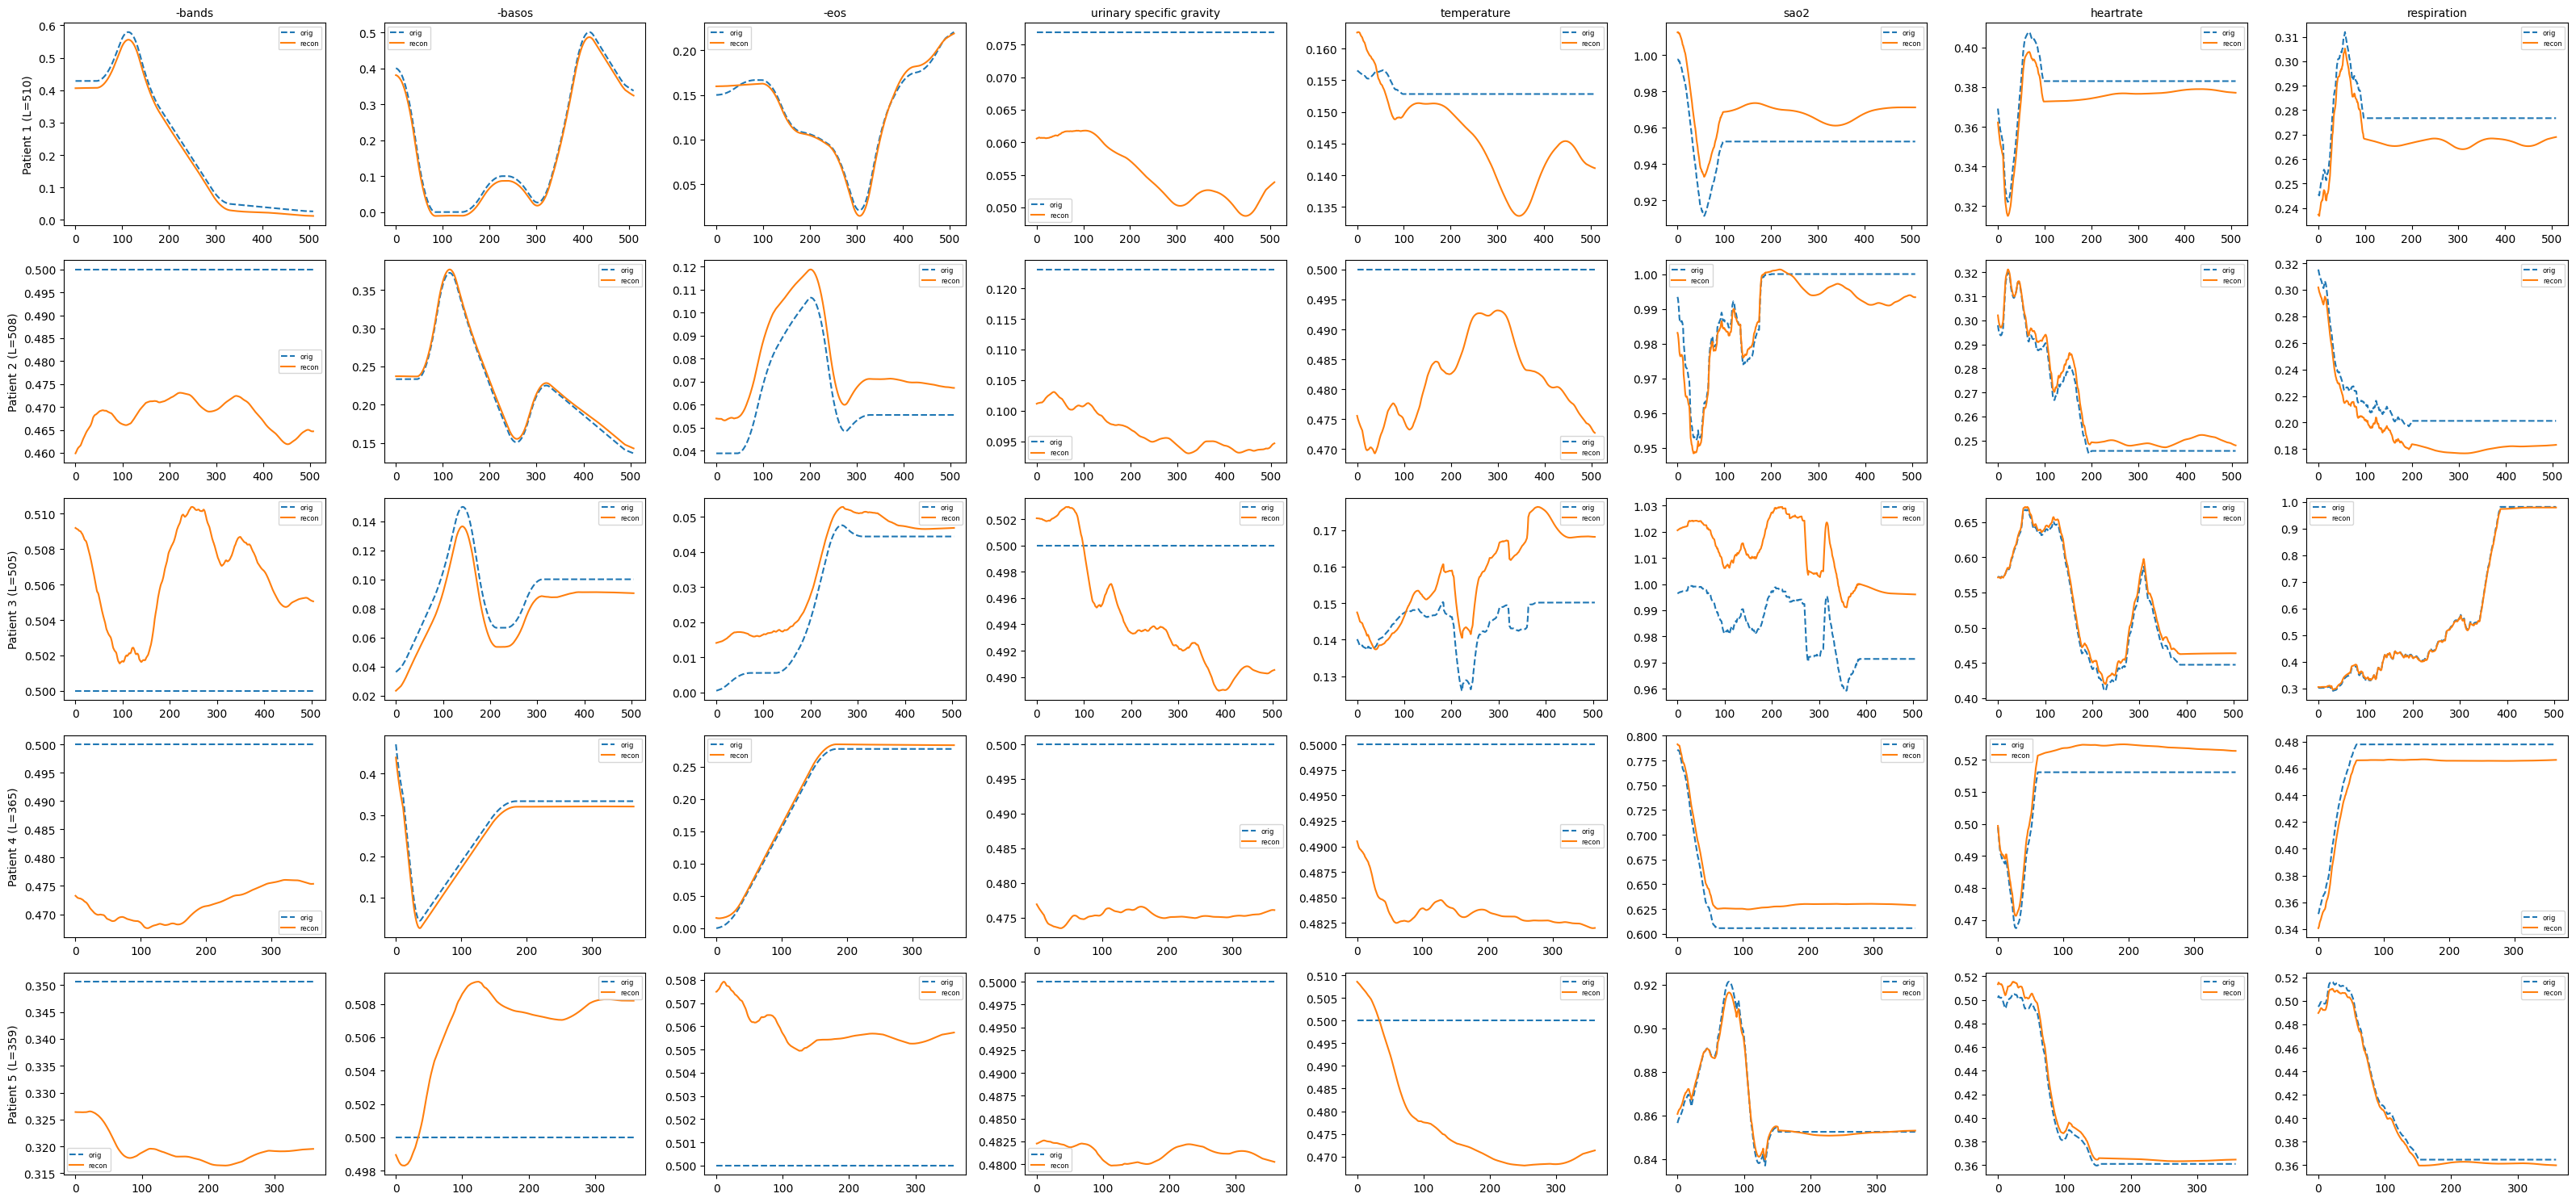

In [9]:
with open('/home/mei/nas/docker/thesis/data/hdf/features.txt', 'r') as f:
    features = [line.strip() for line in f]

selected_feature_indices = [0,1,2,142,143,144,145,146]  #

visualize_recons(model4, train_loader, num_patients=5, feature_indices=selected_feature_indices, feature_names=features,device=device)


--- Latent Space Statistics ---
Analyzed 151690 valid timesteps.

--- mu (Mean of q(z|x)) ---
  Mean (overall): 0.0007
  Std (overall): 0.2272
  Per-dim mean:
tensor([ 0.0076,  0.0581, -0.0678, -0.0717,  0.1600, -0.0093, -0.0697,  0.0873,
        -0.0231,  0.0866,  0.0603,  0.0117, -0.0061, -0.1484,  0.0193, -0.1920,
         0.0817,  0.0198, -0.0341,  0.2535, -0.0628, -0.0788,  0.0474, -0.0475,
        -0.0210, -0.1057,  0.1333, -0.0384,  0.0249,  0.0234, -0.0098,  0.2441,
        -0.0529, -0.0267,  0.0898, -0.0854, -0.0047, -0.1779,  0.1836, -0.0332,
        -0.1826, -0.1293,  0.0086, -0.2415,  0.1092, -0.1736, -0.0743,  0.1171,
        -0.1765, -0.1441, -0.1946,  0.0448,  0.0885, -0.0456,  0.0602,  0.1196,
         0.2024, -0.2226,  0.0897,  0.1688, -0.0875,  0.3802,  0.2433,  0.0997,
        -0.1770,  0.3156, -0.1783, -0.0659, -0.1550, -0.1072, -0.8572, -0.1920,
        -0.0837,  0.0339,  0.2371,  0.1835,  0.1346,  0.0679,  0.1659,  0.0842,
        -0.0248,  0.0455,  0.1821,  0.26

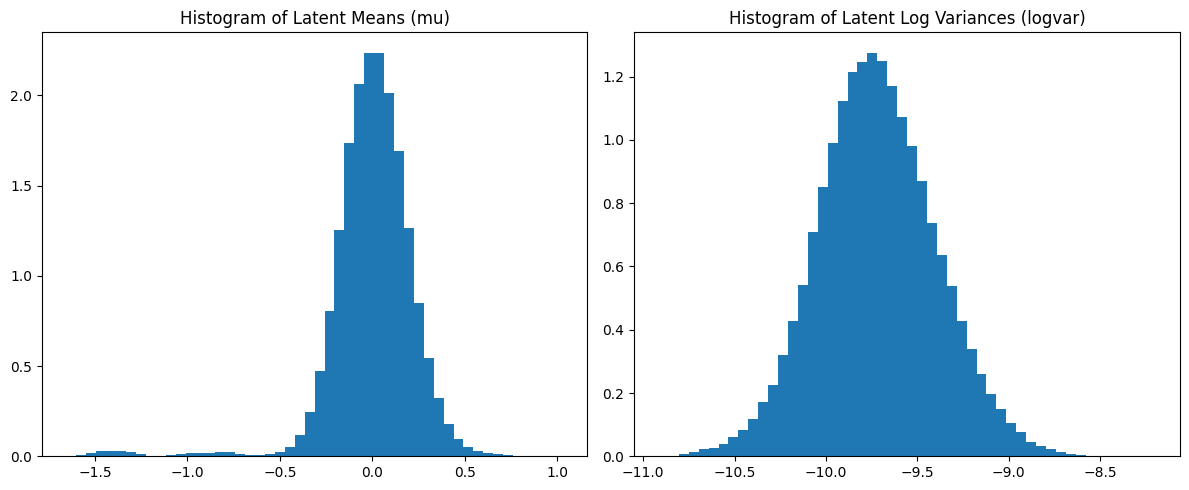

In [12]:
analyze_latent_stats(model4, train_loader, device, num_batches_to_analyze=20)

### vae 几乎退化成 ae， logvar=-10， 无随机性， kl值过大，与先验不服和

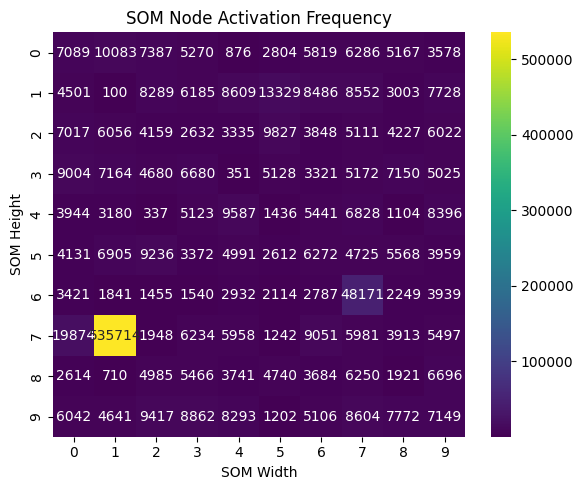

In [15]:
activation_map = compute_som_activation_heatmap(model4,train_loader, device)
plot_som_activation_heatmap(activation_map)

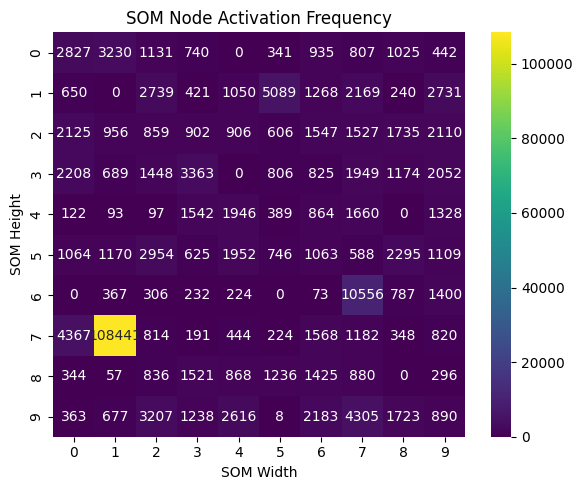

In [17]:
activation_map = compute_som_activation_heatmap(model4,test_loader, device)
plot_som_activation_heatmap(activation_map)

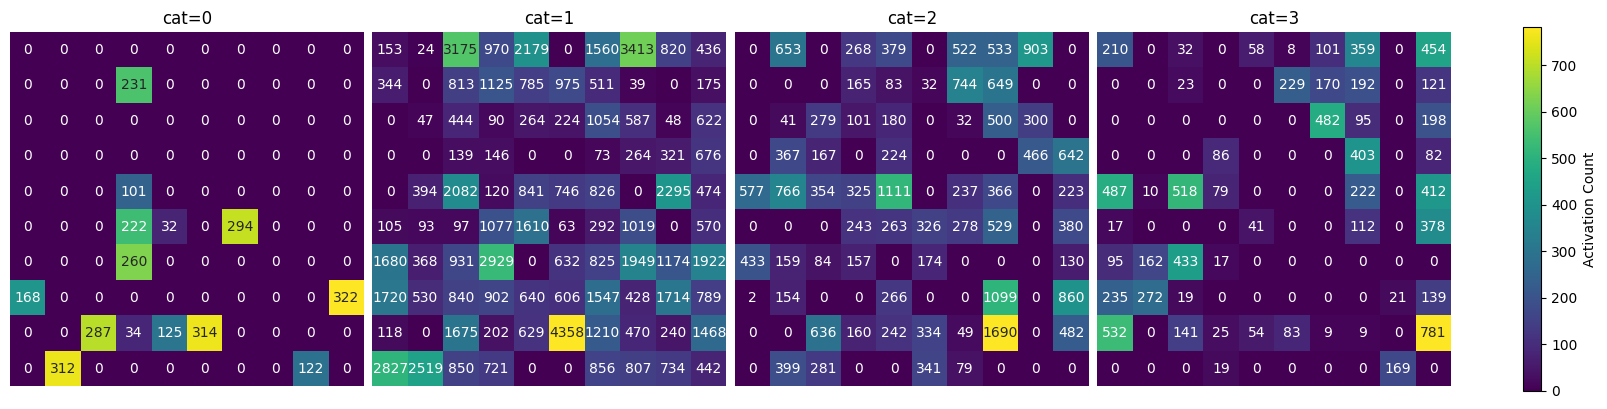

In [18]:

som_dim = (10,10)
hm_by_cat = compute_som_activation_by_category(model4, test_loader, device, som_dim)
plot_som_usage_by_category(hm_by_cat, som_dim)

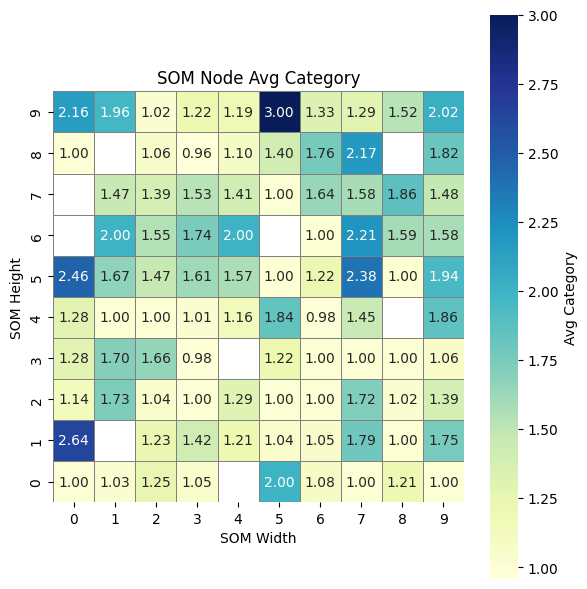

In [19]:

som_dim = (10,10)
avg_cat_map = compute_som_avg_category(model4, test_loader, device, som_dim)
plot_som_avg_category(avg_cat_map, som_dim)

z_all shape: (113724, 128)
y_all shape: (113724,)


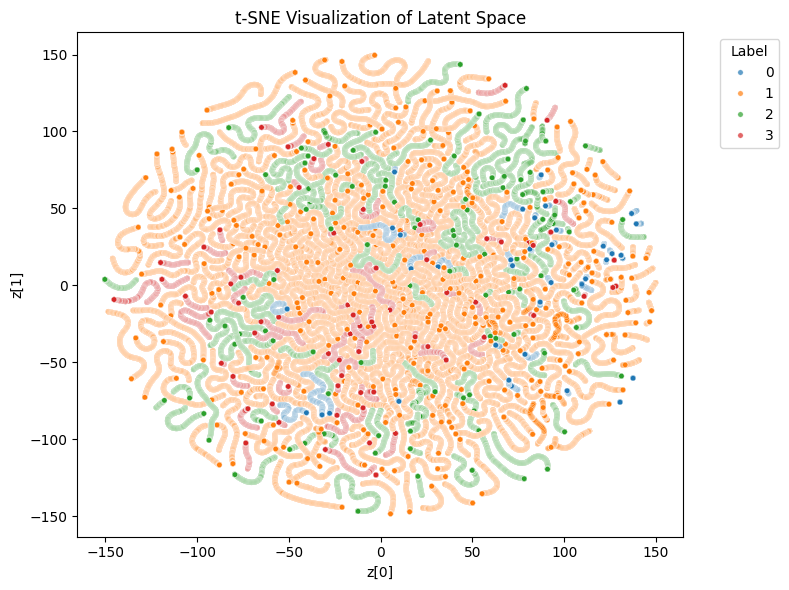

In [20]:
z_all, y_all = collect_latents(model4, data_loader= train_loader, device=device, max_batches=15)
plot_tsne(z_all, y_all)

/home/mei/anaconda3/envs/eicu/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/mei/anaconda3/envs/eicu/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


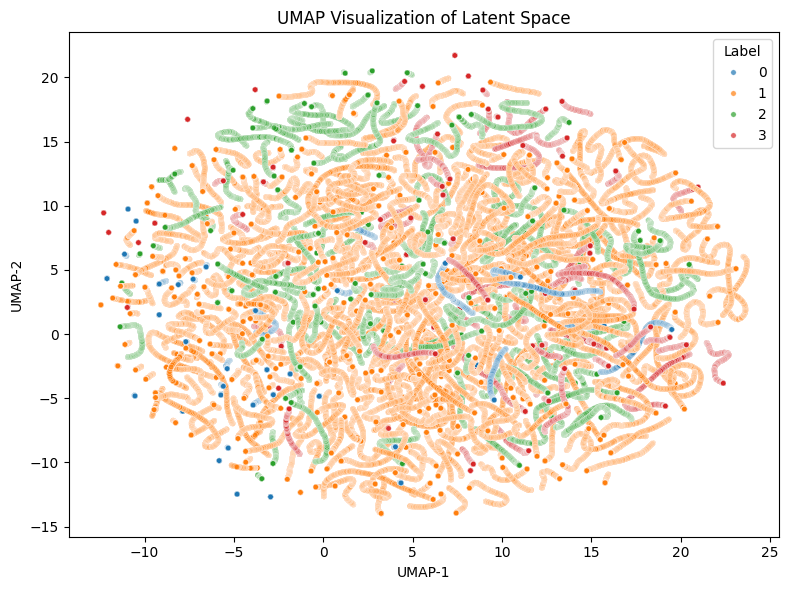

In [21]:
plot_umap(z_all, y_all)